In [41]:
%matplotlib notebook
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot as plt

# font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
 font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'

font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())
import numpy as np

## ランダムな辞書とスパース信号から観測信号を作成
$\bf Y = A_{\rm 0} X$

$\bf{Y} \rm \in R^{30 \times 4000}_{+}$, $\bf A_{\rm 0} \rm \in R^{30 \times 60}_{+}$, $\bf X \rm \in R^{60 \times 4000}_{+}$

In [44]:
A0 = np.random.randn(30, 60)
A0 = np.dot(A0, np.diag(1. / np.sqrt(np.diag(np.dot(A0.T, A0)))))

plt.imshow(A0, cmap='gray', interpolation='Nearest')
plt.colorbar(fraction=0.024, pad=0.04)

<IPython.core.display.Javascript object>


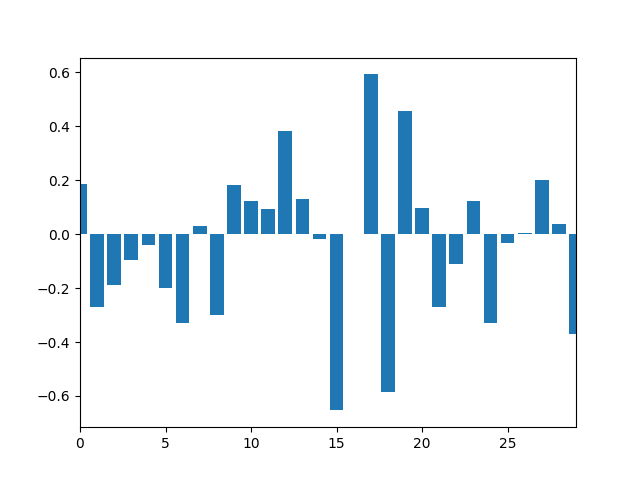

(0, 29)

In [15]:
Y = np.zeros((30, 4000))
sig = 0.1
k0 = 4
for i in range(4000):
    Y[:, i] = np.dot(A0[:, np.random.permutation(range(60))[:k0]], np.random.randn(4)) + np.random.randn(30) * sig
    
plt.bar(range(30), Y[:, 0])
plt.xlim(0, 29)

## 追跡法


In [36]:
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

## 辞書学習アルゴリズム

In [50]:
class DctionaryLearning(object):    
    """ 辞書学習 """         
    def MOD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        MOD辞書学習アルゴリズム 
        
        Y 信号事例、n×M、nは事例の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            opt = np.abs(Y - np.dot(A, X)).mean()
            
            A = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T))))
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
            
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)
    
    def KSVD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        K-SVD辞書学習アルゴリズム
        
        Y 信号事例、n×M、nは信号の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数

        参考
        https://github.com/greyhill/pypbip/blob/master/ksvd.py
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            for j in ndx:      
                x_using = X[j, :] != 0
                if np.sum(x_using) == 0:
                    continue
                X[j, x_using] = 0
                Residual_err = Y[:, x_using] - np.dot(A, X[:, x_using])                 
                U, s, Vt = np.linalg.svd(Residual_err)
                A[:, j] = U[:, 0]
                X[j, x_using] = s[0] * Vt.T[:, 0]

            opt = np.linalg.norm(Y - np.dot(A, X), ord='fro').mean()
            # opt = np.abs(Y - np.dot(A, X)).mean()
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)

    def percent_recovery_of_atoms(self, A, A0, threshold=0.99):
        """ アトムの復元率を測る """
        num = 0
        for m in range(A.shape[1]):
            a = A0[:, m]
            if np.abs(np.dot(a, A)).max() > threshold:
                num += 1
        return float(num) / A.shape[1] * 100

## 合成データから辞書学習

In [51]:
dl = DctionaryLearning()
#A_MOD, log_MOD = dl.MOD(Y, sig, A0.shape[1], k0, A0=A0, n_iter=50)
A_KSVD, log_KSVD = dl.KSVD(Y, sig, A0.shape[1], k0, A0=A0, n_iter=50)

0 (67.890453531309959, 0.0)
1 (61.119299747262225, 0.0)
2 (57.167489758476954, 0.0)
3 (53.999762213647244, 0.0)
4 (51.450187264534541, 0.0)
5 (49.352709358529445, 0.0)
6 (47.059761892947094, 0.0)
7 (45.297011437046677, 0.0)
8 (43.673659604327085, 0.0)
9 (42.0798874742839, 0.0)
10 (40.572077606454251, 0.0)
11 (39.156172662295319, 0.0)
12 (37.678100701362091, 0.0)
13 (36.86273369879207, 0.0)
14 (35.903163173774047, 0.0)
15 (35.209203729020288, 0.0)
16 (35.036584463220656, 0.0)
17 (34.926585635703553, 0.0)
18 (34.850405143004444, 0.0)
19 (34.788921576584919, 0.0)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].plot(log_MOD[:, 0], label='MOD')
ax[0].plot(log_KSVD[:, 0], ls='--', label='K-SVD')
ax[0].set_ylabel('平均表現誤差')
ax[0].set_xlabel('反復回数')
ax[0].legend(loc='best')
ax[0].grid()
# ax[1].plot(log_MOD[:, 1], label='MOD')
ax[1].plot(log_KSVD[:, 1], ls='--', label='K-SVD')
ax[1].set_ylabel('正しく復元されたアトムの割合')
ax[1].set_xlabel('反復回数')
ax[1].legend(loc='best')
ax[1].grid()
plt.savefig('MOD_K-SVD.png', dpi=220)